<a href="https://colab.research.google.com/github/swarajnanda2021/ViT_original/blob/main/ViT_colab_dataAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import libraries
import torch
import torch.nn as nn
from torch.nn import functional as F 
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init
%matplotlib inline

In [5]:

# Download the CIFAR-10 dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
import numpy as np
import sys
import pickle 
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

%matplotlib inline
def load_batch(fpath, label_key='labels'):
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_cifar10():
    x_train = []
    y_train = []
    for i in range(1, 6):
        fpath = './data/cifar-10-batches-py/data_batch_' + str(i)
        data, labels = load_batch(fpath)
        x_train.append(data)
        y_train.append(labels)

    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    x_test, y_test = load_batch("./data/cifar-10-batches-py/test_batch")

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_cifar10()




In [8]:
# Define the model

# We will now write a script for getting image patches

class PatchEmbed(nn.Module):

    '''
    Params:
    -------
    img_size (int)      : size of the image (assumed to be square) 
    patch_size (int)    : size of the patch (assumed to be square)
    in_chans (int)      : number of channels in the image (assumed to be RGB typically)
    embed_dim (int)     : embedding dimension (will be constant throughout the network)
    
    Attributes:
    -----------
    num_patches (int)   : number of patches in the image
    proj (nn.Conv2d)    : convolutional layer to get the patches, will have same stride as patch_size
    '''
    def __init__(self, img_size, patch_size, in_chans=3,embed_dim=256):
        super().__init__() # call the super class constructor which is used to inherit the properties of the parent class
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2 # assuming square image
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride = patch_size
        )
    
    def forward(self, x):
        ''' Parameters: 
        x (torch.Tensor): input image of shape (n_samples or batches, number of channels, height, width)
        Returns: 
        output = n_samplex X n_patches X embed_dim shape tensor
        '''
        x = self.proj(x) # n_samples X embed_dim X sqrt(n_patches) X sqrt(n_patches)
        x = x.flatten(2) # n_sample X embed_dim X n_patches
        x = x.transpose(1, 2) # n_samples X n_patches X embed_dim (dimensions are swapped)

        return x


# Let us now write the attention module
class Attention(nn.Module):
    ''' 
    Parameters
    ----------
    dim (int)           : embedding dimension, 
    n_heads (int)       : number of attention heads
    qkv_bias (bool)     : if True, we will include a bias in the query, key and value projections
    attn_d (float)      : Probability of dropout added to q, k and v during the training
    proj_d (float)      : Probability of dropout added to the projection layer
    
    Attributes
    __________
    scale (float)               : Used for norrmalizing the dot product
    qkv (nn.Linear)             : Linear projection, which are used for performing the attention
    proj (nn.Linear)            : Takes in the concatenated output of all attention heads and maps it further
    attn_d, proj_d (nn.Dropout) : Dropout layers

    '''
    def __init__(self,dim, n_heads=4, qkv_bias = False, attn_d = 0., proj_d = 0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5 # scaling added as per Vaswani paper for not feeding extremely large values to softmas
        self.qkv = nn.Linear(dim,dim * 3, bias = qkv_bias) # can be written separately too
        self.proj = nn.Linear(dim, dim)
        self.proj_d = nn.Dropout(proj_d)
        self.attn_d = nn.Dropout(attn_d)
    
    def forward(self,x):
        ''' 
        Parameters
        ----------
        x (torch.Tensor) : has shape (n_samples/batch, n_patches+1, dim)
        
        Returns
        -------
        torch.Tensor (n_samples, n_patches+1, dim)

        '''
        n_samples, n_tokens, dim = x.shape # extract shapes, tokens and dimensions from the output of the embeddings
        if dim != self.dim:
            raise ValueError # raise an error if dim isn't equal to the dimension set in the attention layer
        
        qkv = self.qkv(x) # Perform the query, key, value projections. (n_samples/batches, n_patches+1, 3*dim), the middle dimension is maintained

        # Let us now reshape the qkv tensor to separate the query, key and value
        qkv = qkv.reshape(n_samples,n_tokens,3,self.n_heads,self.head_dim) # (n_samples, n_patches+1, 3, n_heads, head_dim)
        qkv = qkv.permute(2,0,3,1,4) # (3, n_samples, n_heads, n_patches+1, head_dim)
        # Now extract the query, key and value
        q,k,v = qkv[0], qkv[1], qkv[2] # (n_samples, n_heads, n_patches+1, head_dim)
        # perform the dot product and scale the dot product
        dot_prod = (q @ k.transpose(-2,-1)) * self.scale # (n_samples, n_heads, n_patches+1, n_patches+1)
        # apply a softmax
        attention = dot_prod.softmax(dim = -1) # (n_samples, n_heads, n_patches+1, n_patches+1)
        attention = self.attn_d(attention) # apply dropout for regularization during training
        # weighted average
        wei = (attention @ v).transpose(1,2) # (n_samples, n_patches+1, n_heads, head_dim)
        # flatten
        wei = wei.flatten(2) # (n_samples, n_patches+1, dim) as dim = n_heads * head_dim
        # we now apply the projection
        x = self.proj(wei) # (n_samples, n_patches+1, dim)
        x = self.proj_d(x) # apply dropout for regularization during training
        return x

    # Let us now write the MLP module

class MLP(nn.Module):
    ''' 
    Parameters
    ----------
    in_features (int)           : embedding dimension, 
    hidden_features(int)        : dimension of the hidden layer
    out_features (int)          : dimension of the hidden layer
    dropout (float)     : probability of dropout
    
    Attributes
    __________
    fc1 (nn.Linear)     : Linear projection, which are used for performing the attention
    fc2 (nn.Linear)     : Takes in the concatenated output of all attention heads and maps it further
    dropout (nn.Dropout): Dropout layer

    '''
    def __init__(self, in_features,hidden_features,out_features, dropout=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features) # takes in the input and maps it to the hidden layer
        self.fc2 = nn.Linear(hidden_features, out_features) # takes in the hidden layer and maps it to the output
        self.dropout = nn.Dropout(dropout)
        self.act = nn.GELU() # we will the GELU activation function in the paper
    
    def forward(self, x):
        x = self.fc1(x) # apply the first linear projection, (n_samples, n_patches+1, hidden_features)
        x = self.act(x) # apply the activation function (n_samples, n_patches+1, hidden_features)
        x = self.dropout(x) # apply dropout (n_samples, n_patches+1, hidden_features)
        x = self.fc2(x) # apply the second linear projection (n_samples, n_patches+1, out_features)
        x = self.dropout(x) # apply dropout (n_samples, n_patches+1, out_features)
        return x

# We have everything we need to write the ViT class

class Block(nn.Module):
    ''' Transformer with Vision Token
    Parameters
    ----------
    dim (int)           : embedding
    n_heads (int)       : number of attention heads
    mlp_ratio (float)   : ratio of mlp hidden dim to embedding dim, determines the hidden dimension size of the MLP module
    qkv_bias (bool)     : whether to add a bias to the qkv projection layer
    attn_d, proj_d,          : dropout probabilities

    Attributes
    ----------
    norm1, norm2        :  LayerNorm layers
    attn                : Attention layer
    mlp                 : MLP layer
    '''
    def __init__(self, dim, n_heads, mlp_ratio = 4.0, qkv_bias=True, attn_d=0., proj_d = 0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps = 1e-6) # division by zero is prevented and we match the props of the pretrained model
        self.attn = Attention(dim, n_heads, qkv_bias, attn_d, proj_d)
        self.norm2 = nn.LayerNorm(dim, eps = 1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features = dim, hidden_features = hidden_features, out_features = dim, dropout = proj_d)
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x)) # add to the residual highway after performing Layernorm and attention
        x = x + self.mlp(self.norm2(x)) # add to the residual highway after performing Layernorm and MLP
        return x


# now we can write the Vision Transformer class
class ViT(nn.Module):
    ''' Vision Transformer
    Parameters
    ----------
    image_size (int)            : size of the input image
    patch_size (int)            : size of the patches to be extracted from the input image
    in_channels (int)           : number of input channels
    num_classes (int)           : number of classes
    embed_dim (int              : embedding dimension
    depth (int)                 : number of transformer blocks
    n_heads (int)               : number of attention heads per block
    mlp_ratio (float)           : ratio of mlp hidden dim to embedding dim, determines the hidden dimension size of the MLP module
    qkv_bias (bool)             : whether to add a bias to the qkv projection layer
    attn_d, proj_d,             : dropout probabilities

    Attributes
    ----------
    patch_embed (nn.Conv2d)     : Convolutional embedding layer
    pos_embed (nn.Parameter)    : learnable positional embedding
    cls_token (nn.Parameter)    : learnable class token
    blocks (nn.ModuleList)      : list of transformer blocks
    norm (nn.LayerNorm)         : final LayerNorm layer
    head (nn.Linear)            : final linear projection layer
    '''
    # initialize
    def __init__(self, 
                img_size = 384, 
                patch_size = 16, 
                in_chans=3, 
                n_classes = 1000, 
                embed_dim = 768, 
                depth = 12,
                n_heads = 12,
                mlp_ratio = 4.0,
                qkv_bias = True,
                attn_d = 0.,
                proj_d = 0.):
        super().__init__()
        # we will use the same image size as the pretrained model
        self.patch_embed = PatchEmbed(
                                        img_size = img_size,
                                        patch_size = patch_size,
                                        in_chans = in_chans,
                                        embed_dim = embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim)) # learnable class token
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches + 1, embed_dim)) # learnable positional embedding
        self.pos_d     = nn.Dropout(p = proj_d) # dropout layer
        self.blocks    = nn.ModuleList(
                            [
                                Block( 
                                    dim = embed_dim, 
                                    n_heads = n_heads, 
                                    mlp_ratio = mlp_ratio, 
                                    qkv_bias = qkv_bias, 
                                    attn_d = attn_d, 
                                    proj_d = proj_d) for _ in range(depth)] # iteratively create the transformer blocks with same parameters
                                    )
        self.norm       = nn.LayerNorm(embed_dim, eps = 1e-6) # final LayerNorm layer
        self.head       = nn.Linear(embed_dim, n_classes) # final linear projection layer    

    # forward pass
    def forward(self, x):
        ''' Forward pass
        Parameters
        ----------
        x (torch.Tensor)            : n_samples X in_chans X img_size X img_size
        Returns
        -------
        logits (torch.Tensor)       : n_samples X n_classes
        '''
        n_samples = x.shape[0]
        x = self.patch_embed(x) # extract patches from the input image and turn them into patch embeddings
        cls_tokens = self.cls_token.expand(n_samples, -1, -1) # expand the class token to match the batch size
        # pre-append the class token to the patch embeddings
        x = torch.cat((cls_tokens, x), dim = 1) # n_samples X (n_patches + 1) X embed_dim
        x = x + self.pos_embed # add the positional embedding to the patch embeddings
        x = self.pos_d(x) # apply dropout to the embeddings
        for block in self.blocks: # apply transformer blocks
            x = block(x)
        x = self.norm(x) # apply LayerNorm to the final output
        # the shape of x now is n_samples X (n_patches + 1) X embed_dim
        # extract the class token from the output
        cls_token = x[:, 0] # n_samples X embed_dim
        x = self.head(cls_token) # n_samples X n_classes
        return x


In [70]:
# Write a small test script with a smaller model to train on the cifar10 dataset

# construct model
model = ViT(img_size = 32, 
                    patch_size = 16, 
                    in_chans=3, 
                    n_classes = 10, 
                    embed_dim = 768, 
                    depth = 12,
                    n_heads = 8,
                    mlp_ratio = 4.0,
                    qkv_bias = True,
                    attn_d = 0.2,
                    proj_d = 0.2)

print(f'Total params: {sum(p.numel() for p in model.parameters())}')


# Make some basic image transformations
def augment_image(img):
    # Color jitter
    img = img + 0.1 * torch.randn_like(img)
    
    # Random rotation
    angle = 30 * torch.randn(1).item()
    angle = angle / 180 * 3.14
    angle = torch.tensor(angle)
    rotation_matrix = torch.tensor([
        [torch.cos(angle), -torch.sin(angle), 0],
        [torch.sin(angle), torch.cos(angle), 0]
    ]).unsqueeze(0)
    grid = F.affine_grid(rotation_matrix, torch.Size([1, 3, 32, 32]))
    grid = grid.to(device)
    img = F.grid_sample(img.unsqueeze(0), grid, mode='bilinear', padding_mode='zeros').squeeze(0)
    
    # Channel shuffling
    channel_shuffle_order = torch.randperm(3)
    img = img[channel_shuffle_order, :, :]

    # Random Flipping
    flip_dir = torch.randint(2, (1,)).item()
    if flip_dir == 0:
        img = torch.flip(img, [2]) # flip horizontally
    else:
        img = torch.flip(img, [1]) # flip vertically
    
    
    return img




# Initialize the weights
for m in model.modules():
    if isinstance(m, nn.Linear):
        init.normal_(m.weight, std = 0.02)
        if m.bias is not None:
            init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        init.ones_(m.weight)
        init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode = 'fan_in', nonlinearity = 'leaky_relu')
        if m.bias is not None:
            init.zeros_(m.bias)

# load data and convert to torch tensors
x_train, y_train, x_test, y_test = load_cifar10()
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.FloatTensor(y_test).long()

print(f'Training set:: input: {x_train.shape}, output: {y_train.shape}')
print(f'Test set:: input: {x_test.shape}, output: {y_test.shape}')

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4) # use Adam optimizer with a small learning rate

# Send all to device
device = torch.device("cuda")
model = model.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# define a function to get mini batches of data
def get_batch(mode):
    if mode == 'train':
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        xb = x_train[idx]
        yb = y_train[idx]
    elif mode == 'test':
        idx = np.random.randint(0, x_test.shape[0], batch_size)
        xb = x_test[idx]
        yb = y_test[idx]
    return xb,yb

# Write a function to evaluate the loss on the training and test set
def estimate_loss():
    losses = {}
    for mode in ['train', 'val']:
        if mode == 'train':
            xb,yb = get_batch('train')
        elif mode == 'val':
            xb,yb = get_batch('test')
        logits = model(xb)
        loss = criterion(logits, yb)
        losses[mode] = loss.item()
    return losses

# train the model
max_iters = 1000
batch_size = 32
eval_interval = 10
lossi_train = []
lossi_test = []
for i in range(max_iters):
    # print training and testing loss
    if i % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {i}: train loss = {losses['train']:.4f}, val loss = {losses['val']:.4f}")
    # sample from the batch
    imgs,yb = get_batch('train')
    # perform a randomized data augmentation of the inputs
    imgs = [augment_image(img) for img in imgs]
    xb = torch.stack(imgs)
    # forward pass
    logits = model(xb)
    loss = criterion(logits, yb)
    lossi = estimate_loss()
    lossi_train.append(lossi['train'])
    lossi_test.append(lossi['val'])
    # backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
loss_fin = estimate_loss()
print(f"step {i}: train loss = {loss_fin['train']:.4f}, val loss = {loss_fin['val']:.4f}")
    



Total params: 38231562
Training set:: input: torch.Size([50000, 3, 32, 32]), output: torch.Size([50000])
Test set:: input: torch.Size([10000, 3, 32, 32]), output: torch.Size([10000])
step 0: train loss = 2.3480, val loss = 2.4216
step 10: train loss = 2.4423, val loss = 2.5004
step 20: train loss = 2.4349, val loss = 2.3156
step 30: train loss = 2.2554, val loss = 2.3555
step 40: train loss = 2.2947, val loss = 2.2994
step 50: train loss = 2.3335, val loss = 2.3201
step 60: train loss = 2.3784, val loss = 2.4202
step 70: train loss = 2.3368, val loss = 2.3672
step 80: train loss = 2.3682, val loss = 2.3131
step 90: train loss = 2.2543, val loss = 2.3595
step 100: train loss = 2.3024, val loss = 2.3911
step 110: train loss = 2.3514, val loss = 2.3516
step 120: train loss = 2.3219, val loss = 2.3600
step 130: train loss = 2.3402, val loss = 2.3352
step 140: train loss = 2.5210, val loss = 2.4290
step 150: train loss = 2.3337, val loss = 2.2913
step 160: train loss = 2.3467, val loss = 2.

Text(0, 0.5, 'cross entropy loss')

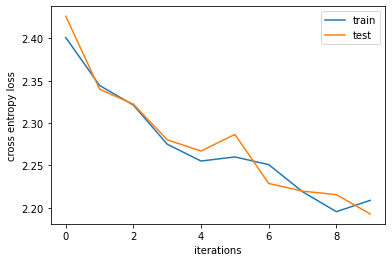

In [71]:
# plot the loss function
lossi_train_mean = torch.Tensor(lossi_train).view(-1,100).mean(1)
lossi_test_mean = torch.Tensor(lossi_test).view(-1,100).mean(1)
plt.plot(lossi_train_mean, label = 'train')
plt.plot(lossi_test_mean, label = 'test')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('cross entropy loss')

In [69]:
# Show an example of a picture and its prediction on the side, also plot the attention weights
import seaborn as sns

## Extract the attention weights from your model
#layer_number = ... # Choose a specific layer number
#head_number = ... # Choose a specific head number
#weights = model.transformer.layer[layer_number].attention.self.weights[head_number].detach().numpy()

# Make some basic image transformations
def augment_image(img):
    # Color jitter
    img = img + 0.1 * torch.randn_like(img)
    
    # Random rotation
    angle = 30 * torch.randn(1).item()
    angle = angle / 180 * 3.14
    angle = torch.tensor(angle)
    rotation_matrix = torch.tensor([
        [torch.cos(angle), -torch.sin(angle), 0],
        [torch.sin(angle), torch.cos(angle), 0]
    ]).unsqueeze(0)
    grid = F.affine_grid(rotation_matrix, torch.Size([1, 3, 32, 32]))
    grid = grid.to(device)
    img = F.grid_sample(img.unsqueeze(0), grid, mode='bilinear', padding_mode='zeros').squeeze(0)
    
    # Channel shuffling
    channel_shuffle_order = torch.randperm(3)
    img = img[channel_shuffle_order, :, :]

    # Random Flipping
    flip_dir = torch.randint(2, (1,)).item()
    if flip_dir == 0:
        img = torch.flip(img, [2]) # flip horizontally
    else:
        img = torch.flip(img, [1]) # flip vertically

    
    return img


# class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def pred2label(pred):
    return class_names[pred]


def show_example():
    imgs,yb = get_batch('train')
    imgs = [augment_image(img) for img in imgs]
    xb = torch.stack(imgs)
    logits = model(xb)
    pred = torch.argmax(logits, dim = 1)
    plt.figure(figsize=(2,2))
    plt.imshow(xb[0].cpu().numpy().transpose(1,2,0).astype('uint8'))
    # Plot the attention weights as a heatmap
    #sns.heatmap(weights, cmap="YlGnBu")
    plt.title(f'Prediction: {class_names[pred[0].item()]}, Actual: {class_names[yb[0].item()]}')
    plt.show()
    
show_example()

RuntimeError: ignored